In [1]:
""" Analyze hydrographs to finds past occurrence of the minimum flow requirement goes unmet"""

' Analyze hydrographs to finds past occurrence of the minimum flow requirement goes unmet'

' Get daily hydrographs over the remote sensing peiod of record. '

In [24]:
import os

# local imports
from utils.hydrograph import read_hydrograph, get_station_flows

HSTART, HEND = 1980, 2022

# we're using clark fork at turah, but we could do any other gage
stations = {'12334550': (500, 'Clark Fork at Turah Bridge nr Bonner MT', isf)}
sid = '12334550'

others = {'06052500': (947, 'Gallatin River at Logan MT', None),
          '06076690': (150, 'Smith River near Ft Logan MT', None),
          '06195600': (945, 'Shields River nr Livingston MT', None),
          '12340000': (700, 'Blackfoot River near Bonner MT', None)}

home = os.path.expanduser("~")
root = os.path.join(home, 'Downloads')
if not os.path.exists(root):
    os.makedirs(root)
    
isf = os.path.join(root, sid, 'milltown_isf.csv')

overwrite = False

In [25]:
""" Get gage hydrographs """
for k, v in stations.items():
    print(k)
    gage = os.path.join(root, k)
    insta = os.path.join(gage, 'insta_q')

    if not os.path.exists(gage):
        os.makedirs(gage)
    if not os.path.exists(insta):
        os.makedirs(insta)

    h = os.path.join(gage, '{}.csv'.format(k))

    if not os.path.exists(h) or overwrite:

        s, e = '{}-01-01'.format(HSTART), '{}-12-31'.format(HEND + 1)
        get_station_flows(s, e, k, freq='dv', out_dir=gage, overwrite=True)

        for y in range(HSTART, HEND + 1):
            s, e = '{}-01-01'.format(y), '{}-12-31'.format(y)
            get_station_flows(s, e, k, freq='iv', out_dir=insta, overwrite=True)
            _file = os.path.join(insta, '{}.csv'.format(k))
            o_file = os.path.join(insta, '{}_{}.csv'.format(k, y))
            if os.path.exists(_file):
                os.rename(_file, o_file)
                
    else:
        print(h, 'exists')

12334550
/home/dgketchum/Downloads/12334550/12334550.csv exists


In [26]:
""" Analyze gages for low-flow events and plot the hydrograph data """
import json

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter

min_flow=stations[sid][0]
long_name=stations[sid][1] 
schedule=stations[sid][2]

print('\n{}'.format(os.path.basename(h)))
df = read_hydrograph(h)
name = df.columns[0]
df['date'] = df.index
df['year'] = df.date.dt.year
df['date'] = df.date.dt.strftime('%m-%d')
df.index = [x for x in range(0, df.shape[0])]
ydf = df.set_index(['year', 'date'])[name].unstack(-2)
ydf.dropna(axis=1, how='all', inplace=True)
ldf = ydf.copy()
cols = ldf.columns
s, e = '05-01', '10-31'
mins = [(c, ldf[c][s: e].idxmin(), ldf[c][s: e].min()) for c in cols if ldf[c][s: e].min() < min_flow]
ldf = ldf[[y[0] for y in mins]]
ldf[ldf.values >= min_flow] = np.nan
ldf = ldf.loc[s: e, :]
periods = []
unverified = []

for k, v in tqdm(ldf.items(), total=len(ldf.keys())):
    if k < 1994:
        continue
    d = pd.DataFrame(v)
    d['ix'] = [x for x in range(0, d.shape[0])]
    d['lf'] = (d[k] < min_flow)
    d['crossing'] = (d.lf != d.lf.shift()).cumsum()
    d['count'] = d.groupby(['lf', 'crossing']).cumcount(ascending=True)
    d['rolling'] = d['lf'].rolling(5).sum()

    if d['rolling'].max() < 4:
        continue

    missing = False
    inst_csv = os.path.join(insta, '{}_{}.csv'.format(sid, k))
    try:
        iv = read_hydrograph(inst_csv)

        full_days = []

        for i, r in d.iterrows():
            day = iv.loc['{}-{}'.format(k, i): '{}-{}'.format(k, i)]
            if day.empty:
                full_days.append(False)
                missing = True
            else:
                day = day.values
                full_days.append(np.all(day < min_flow))

    except FileNotFoundError:
        missing = True

    summer_min = d[k].min()

    if missing:
        d = d[d['rolling'] > 4]
        lf_days = np.count_nonzero(d['lf'])
        unverified.append(k)
    else:
        d['lf_update'] = full_days
        d['crossing_update'] = (d.lf != d.lf.shift()).cumsum()
        d['count_update'] = d.groupby(['lf_update', 'crossing_update']).cumcount(ascending=True)
        lf_days = np.count_nonzero(d['lf_update'])
        d = d[(d['count_update'] >= 4) & (d['lf_update'] == 1)]
        if d.empty:
            continue

    window = k, d.index[0], lf_days, summer_min
    periods.append(window)

if schedule:
    schedule = pd.read_csv(schedule, infer_datetime_format=True, parse_dates=True, index_col=0)
    schedule = schedule[schedule.columns[0]]
    schedule.index = ydf.index
else:
    schedule = pd.DataFrame(data=[min_flow for _ in ydf.index], index=ydf.index)

print('Low-flow years: {}'.format(periods))

print('{} low-flow years, {} gage years, {} unverified\n'.format(len(periods), len(ldf.columns),
                                                                 len(unverified)))


12334550.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  7.58it/s]

Low-flow years: [(1994, '08-07', 59, 302.0), (2000, '07-21', 70, 253.0), (2001, '08-20', 48, 322.0), (2003, '08-16', 30, 432.0), (2004, '08-14', 15, 374.0), (2006, '08-02', 49, 364.0), (2007, '08-14', 24, 427.0), (2013, '08-18', 35, 379.0), (2015, '08-15', 26, 373.0), (2016, '08-05', 48, 342.0), (2017, '09-01', 10, 456.0), (2022, '08-21', 24, 392.0)]
12 low-flow years, 22 gage years, 2 unverified



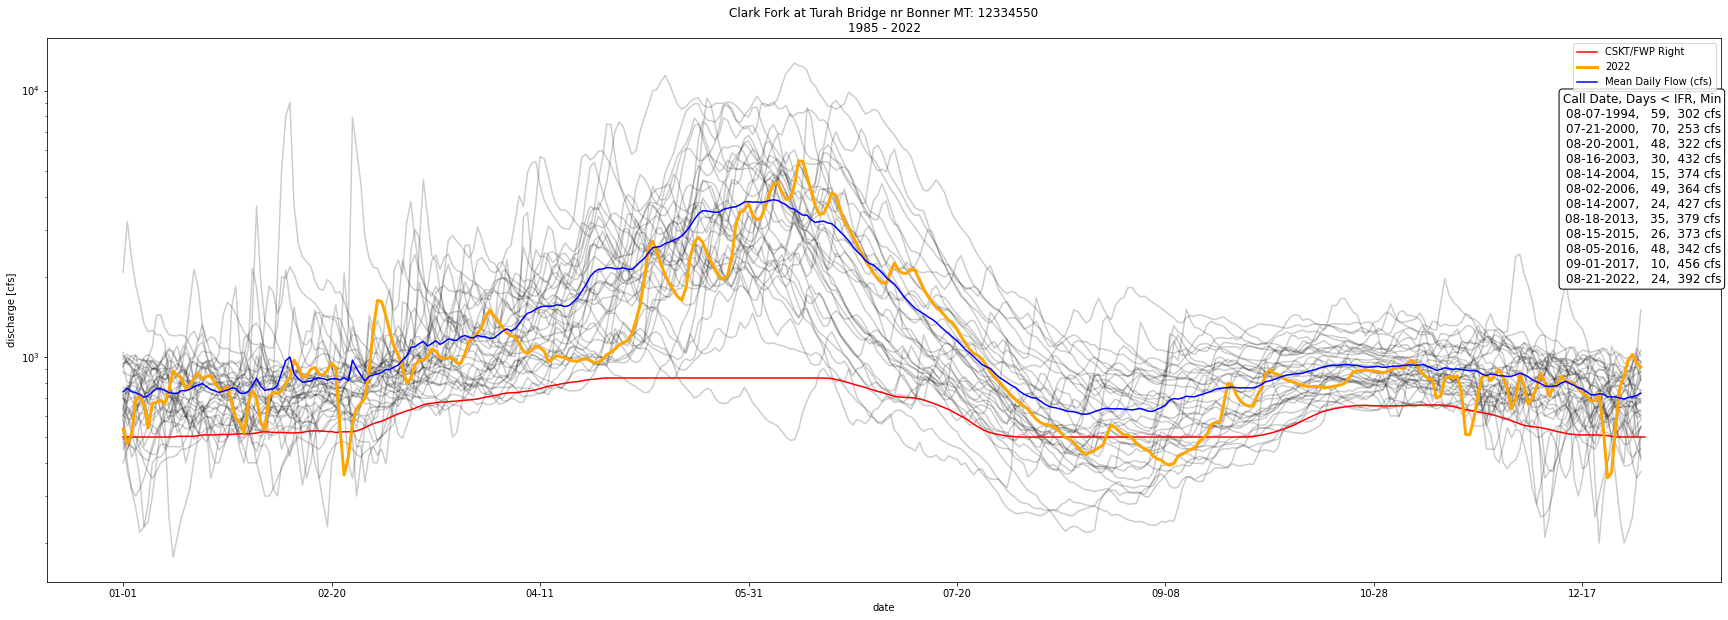

In [28]:
    colors = ['k' for _ in ydf.columns]
    years = [int(c) for c in ldf.columns]
    ax = ydf.plot(logy=True, legend=False, alpha=0.2, color=colors, ylabel='discharge [cfs]',
                  title='{}: {}\n'
                        '{} - {}'.format(long_name, sid, years[0], years[-1]), figsize=(30, 10))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

    ydf = ydf.loc[ydf.index != '02-29']
    ydf.dropna(how='any', axis=1, inplace=True)

    schedule.plot(logy=True, legend=True, color='r', ax=ax)

    last_year = pd.DataFrame(ydf[2022])
    last_year.plot(logy=True, legend=True, color='orange', ax=ax, linewidth=3)

    mean_ = pd.DataFrame(ydf.mean(axis=1))
    mean_.columns = ['Mean Daily Flow (cfs)']
    mean_.plot(logy=True, legend=True, color='b', ax=ax)

    head = ['Call Date, Days < IFR, Min']
    ann = head + [('{}-{},   {},  {:.0f} cfs'.format(p[1], p[0], p[2], p[3])) for p in periods]
    txt = '\n'.join(ann)
    props = dict(boxstyle='round', facecolor='white', alpha=1)

    ax.text(1, 0.9, txt, transform=ax.transAxes, fontsize=12,
            horizontalalignment='right', verticalalignment='top', bbox=props)

    plt.savefig(os.path.join(root, 'stacked_{}'.format(sid)))
    plt.show()